In [1]:
import os
import json
from glob import glob
from PIL import Image

def load_report_with_images(
    json_dir="../data/DITrans-EMNLP/political_report/jsons/",
    img_dir ="../data/DITrans-EMNLP/political_report/imgs/",
    limit=None        # <── here
):
    json_paths = sorted(glob(os.path.join(json_dir, "*.json")))

    if limit is not None:
        json_paths = json_paths[:limit]

    items = []

    for jp in json_paths:
        base = os.path.splitext(os.path.basename(jp))[0]

        # match image
        img_path = None
        for ext in ["jpg", "jpeg", "png"]:
            candidate = os.path.join(img_dir, f"{base}.{ext}")
            if os.path.exists(candidate):
                img_path = candidate
                break

        if img_path is None:
            print(f"[WARN] No image for {base}")
            continue

        with open(jp, "r", encoding="utf-8") as f:
            data = json.load(f)

        img = Image.open(img_path).convert("RGB")

        items.append((base, data, img))


    return items

# ---- USE IT ----
items = load_report_with_images(limit=10)
print("Loaded:", len(items))

Loaded: 10


In [3]:
from transformers import pipeline


translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="mal_Mlym")
translator(["Hello, how are you?", "This is a test sentence."])

Device set to use cuda:0


[{'translation_text': 'ഹലോ, എങ്ങിനെ പോകുന്നു?'},
 {'translation_text': 'ഇത് ഒരു പരീക്ഷണ വാക്യമാണ്.'}]

In [4]:
docs = []
for filename, data, image in items[:10]:
    sentences = {}
    for obj in data.get("objects", []):
        for sen in obj.get("sentences", []):
            info = sen.get("line_info", {})
            sen_id = sen.get("sen_id")
            src = info.get("text_gt")
            tgt = info.get("text_trans_ref")
            if sen_id in sentences.keys():
                if src[0] != ' ':
                    src = ' ' + src
                sentences[sen_id]['src'] += src
            else:
                sentences[sen_id] = {
                    'src': src,
                    'tgt': tgt,
                    'sen_id': sen_id,
                }

    docs.append({
        "sentences": sentences,
    })

docs[1]

{'sentences': {1: {'src': 'For more information on this publication, visit www.rand.org/t/RR2442',
   'tgt': '有关本出版物的更多信息，请访问www.rand.org/t/RR2442',
   'sen_id': 1},
  2: {'src': 'Published by the RAND Corporation, Santa Monica, Calif.',
   'tgt': '兰德公司出版，加州圣莫尼卡',
   'sen_id': 2},
  3: {'src': '©Copyright 2018 RAND Corporation RAND is a registered trademark.',
   'tgt': '©版权所有2018年兰德公司兰德是注册商标。',
   'sen_id': 3},
  4: {'src': 'Limited Print and Electronic Distribution Rights',
   'tgt': '有限的印刷和电子发行权',
   'sen_id': 4},
  5: {'src': 'This document and trademark(s) contained herein are protected by law.',
   'tgt': '本文件和本文件所载商标（或）受法律保护。',
   'sen_id': 5},
  6: {'src': 'This representation of RAND intellectual property is provided for noncommercial use only.',
   'tgt': '兰德公司知识产权的这种表述仅供非商业用途。',
   'sen_id': 6},
  7: {'src': 'Unauthorized posting of this publication online is prohibited.',
   'tgt': '禁止未经授权在网上发布本出版物。',
   'sen_id': 7},
  8: {'src': 'Permission is given to duplicate this docu

In [50]:
from tqdm import tqdm

translator = pipeline("translation", model="facebook/nllb-200-3.3B", src_lang="eng_Latn", tgt_lang="zho_Hans")
# translator = pipeline("translation", model="facebook/nllb-200-distilled-600M", src_lang="eng_Latn", tgt_lang="zho_Hans")


for doc in tqdm(docs):
    sources = [doc['sentences'][sen_id]['src'] for sen_id in doc['sentences'].keys()]
    targets = sources = [doc['sentences'][sen_id]['tgt'] for sen_id in doc['sentences'].keys()]
    translated = translator(sources, max_length=400)
    for i, sen_id in enumerate(doc['sentences'].keys()):
        doc['sentences'][sen_id]['translated_pro'] = translated[i]['translation_text']

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Device set to use cuda:0
100%|██████████| 10/10 [00:52<00:00,  5.28s/it]


In [51]:
import sacrebleu

refs = []
preds = []

for doc in docs:
    pred, ref = [], []
    for sen_id, sen in doc["sentences"].items():
        pred.append(sen["translated_pro"])
        ref.append(sen["tgt"])
    preds.append(" ".join(pred))
    refs.append(" ".join(ref))

# for doc in docs[:1]:
#     for sen_id, sen in doc["sentences"].items():
#         preds.append(sen["translated2"])
#         refs.append(sen["tgt"])

# sacrebleu expects: 
#   predictions = list[str] 
#   references = list[list[str]]  (list of refs)
bleu = sacrebleu.corpus_bleu(preds, [refs], tokenize='char')

print("BLEU:", bleu.score)

BLEU: 67.78293984505483


In [7]:
docs[0]

{'sentences': {1: {'src': 'RAND',
   'tgt': '兰德公司',
   'sen_id': 1,
   'translated2': '兰德公司'},
  2: {'src': 'JUSTICE,INFRASTRUCTURE,AND ENVIRONMENT',
   'tgt': '正义、基础设施与环境',
   'sen_id': 2,
   'translated2': '正义,基础设施与环境'},
  3: {'src': 'Is Climate Restoration an Appropriate Climate Policy  Goal？',
   'tgt': '恢复气候是一个适当的气候政策目标吗？',
   'sen_id': 3,
   'translated2': '恢复气候是适当的气候政策目标吗?'},
  4: {'src': 'Robert J. Lempert,Giacomo Marangoni ,Klaus Keller,Jessica Duke',
   'tgt': '罗伯特·J·兰佩尔，贾科莫·马兰戈尼，克劳斯·凯勒，杰西卡·杜克',
   'sen_id': 4,
   'translated2': '罗伯特·J·兰佩尔,贾科莫·马兰戈尼,克劳斯·凯勒,杰西卡·杜克'},
  5: {'src': 'Prepared for the RAND Frederick S. Pardee Center for Long Range Global Policy and the Future Human Condition',
   'tgt': '为兰德弗雷德里克-S-帕迪长期全球政策和未来人类状况中心准备',
   'sen_id': 5,
   'translated2': '为兰德弗雷德里克-S-帕迪长期全球政策和未来人类状况中心的准备'}}}

In [40]:
def boxes_overlap(b1, b2, threshold=0.01):
    """Return True if IoU > threshold."""
    xa = max(b1["x_min"], b2["x_min"])
    ya = max(b1["y_min"], b2["y_min"])
    xb = min(b1["x_max"], b2["x_max"])
    yb = min(b1["y_max"], b2["y_max"])

    inter_w = max(0, xb - xa)
    inter_h = max(0, yb - ya)
    inter = inter_w * inter_h

    area1 = (b1["x_max"] - b1["x_min"]) * (b1["y_max"] - b1["y_min"])
    area2 = (b2["x_max"] - b2["x_min"]) * (b2["y_max"] - b2["y_min"])

    union = area1 + area2 - inter
    if union == 0:
        return False

    return inter / union > threshold


def combine_overlapping(sentences):
    """Merge overlapping sentence boxes (keep upper-left one)."""
    ids = sorted(sentences.keys())
    merged = {}
    used = set()

    for i in ids:
        if i in used:
            continue

        s1 = sentences[i]
        box1 = s1["box"]

        # this cluster will merge all overlaps into s1
        cluster_ids = [i]

        for j in ids:
            if j in cluster_ids or j in used:
                continue
            s2 = sentences[j]
            box2 = s2["box"]

            if boxes_overlap(box1, box2):
                # add to cluster
                cluster_ids.append(j)

                # merge bounding box
                box1 = {
                    "x_min": min(box1["x_min"], box2["x_min"]),
                    "y_min": min(box1["y_min"], box2["y_min"]),
                    "x_max": max(box1["x_max"], box2["x_max"]),
                    "y_max": max(box1["y_max"], box2["y_max"]),
                }

        # Determine cluster head (top-left)
        top_left = min(
            cluster_ids,
            key=lambda k: (sentences[k]["box"]["y_min"], sentences[k]["box"]["x_min"])
        )

        # Merge texts
        merged_text = ""
        merged_tgt = ""

        for cid in sorted(cluster_ids):
            merged_text += " " + sentences[cid]["src"]
            if sentences[cid]["tgt"]:
                merged_tgt += " " + sentences[cid]["tgt"]

        merged[top_left] = {
            "src": merged_text.strip(),
            "tgt": merged_tgt.strip(),
            "sen_id": top_left,
            "box": box1,
        }

        used.update(cluster_ids)

    return merged


docs = []
for filename, data, image in items:
    sentences = {}
    for obj in data.get("objects", []):
        for sen in obj.get("sentences", []):
            info = sen.get("line_info", {})
            sen_id = sen.get("sen_id")
            src = info.get("text_gt")
            tgt = info.get("text_trans_ref")
            box = info.get("line_box")
            x_min, y_min, x_max, y_max = box[0]['x'], box[0]['y'], box[2]['x'], box[2]['y']
            if sen_id in sentences.keys():
                if src[0] != ' ':
                    src = ' ' + src
                sentences[sen_id]['src'] += src
                curr_box = sentences[sen_id]['box']
                sentences[sen_id]['box'] = {
                    'x_min': min(x_min, curr_box['x_min']),
                    'y_min': min(y_min, curr_box['y_min']),
                    'x_max': max(x_max, curr_box['x_max']),
                    'y_max': max(y_max, curr_box['y_max']),
                }
            else:
                sentences[sen_id] = {
                    'src': src,
                    'tgt': tgt,
                    'sen_id': sen_id,
                    'box': {
                        'x_min': x_min,
                        'y_min': y_min,
                        'x_max': x_max,
                        'y_max': y_max,
                    }
                }
        sentences = combine_overlapping(sentences)

    docs.append({
        "sentences": sentences,
    })
    
len(docs[1]['sentences'])

10

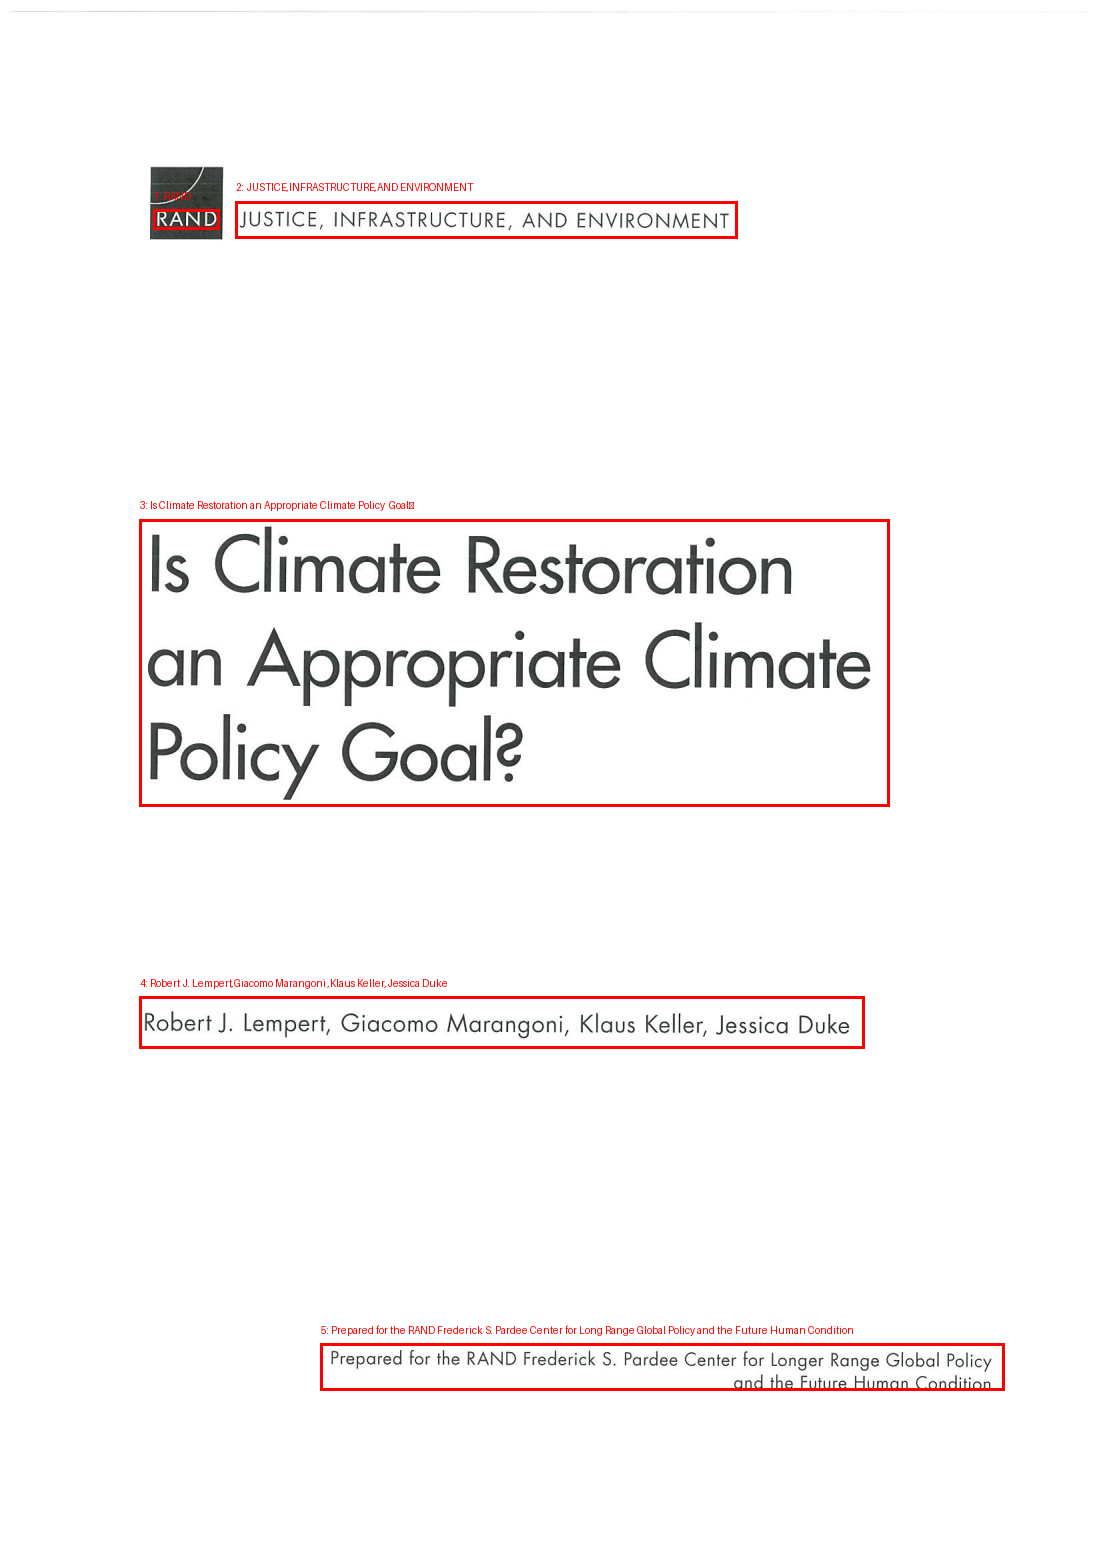

In [42]:
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display

def visualize_doc(image, doc, show_text=True, color="red", width=3):
    """
    Draw sentence boxes from `doc` onto `image`.

    image: PIL.Image
    doc:   {"sentences": {sen_id: {...}}}
    """
    img = image.copy()
    draw = ImageDraw.Draw(img)

    # Optional font (PIL default works, but you can load a TTF)
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except:
        font = ImageFont.load_default()

    for sen_id, sen_data in doc["sentences"].items():
        box = sen_data["box"]

        x_min = box["x_min"]
        y_min = box["y_min"]
        x_max = box["x_max"]
        y_max = box["y_max"]

        # Draw rectangle
        draw.rectangle([(x_min, y_min), (x_max, y_max)], outline=color, width=width)

        # Draw ID or text
        if show_text:
            text = f"{sen_id}: {sen_data['src']}"
            draw.text((x_min, y_min - 20), text, fill=color, font=font)

    return img

idx = 0
img = visualize_doc(items[idx][2], docs[idx])
display(img)

In [52]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("token-classification", model="nielsr/layoutlmv3-finetuned-funsd")

Device set to use cuda:0


In [1]:
# Load model directly
from transformers import AutoProcessor, AutoModelForTokenClassification

processor = AutoProcessor.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")
model = AutoModelForTokenClassification.from_pretrained("nielsr/layoutlmv3-finetuned-funsd")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'RobertaTokenizer'. 
The class this function is called from is 'LayoutLMv3TokenizerFast'.


In [2]:
processor(img)

NameError: name 'img' is not defined

In [9]:
from transformers import LayoutLMv3ImageProcessor, AutoTokenizer, LayoutLMv3Processor

image_processor = LayoutLMv3ImageProcessor()  # apply_ocr is set to True by default
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlmv3-base")
processor = LayoutLMv3Processor(image_processor, tokenizer)

In [26]:
from transformers import LayoutLMv2Processor
from PIL import Image

processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base")

image = Image.open('../data/DITrans-EMNLP/political_report/imgs/1_Is Climate Restoration an Appropriate Climate Policy Goal_01.jpg').convert("RGB")
encoding = processor(image, return_tensors="pt")
tokenizer.decode(encoding['input_ids'][0])
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox', 'labels', 'image'])

'<s> For more information on this publication, visit www.rand.org//RR2442 Published by the RAND Corporation, Santa Monica, Calif © Copyright 2018 RAND Corporation RAND? is a registered trademark Limited Print and Electronic Distribution Rights contained herein are protected by law. This representation of RAND ial use only. Unauthorized posting of chis publication This document and trademark(s) intellectual property is provided for noncomme online is prohibited. Permission is given to duplicate this document for personal use only, as long as it altered and complete. Permission is required from RAND to reproduce, or reuse in another form, any of its research documents for commercial use. For information on reprint and linking permissions, please visit www.rand.org/pubs/permissions. is w ‘The RAND Corporation is a research organization that develops solutions to public policy challenges to help make communiti cure, healthier and more prosperous. RAND is nonprofic, nonpart :s throughout th

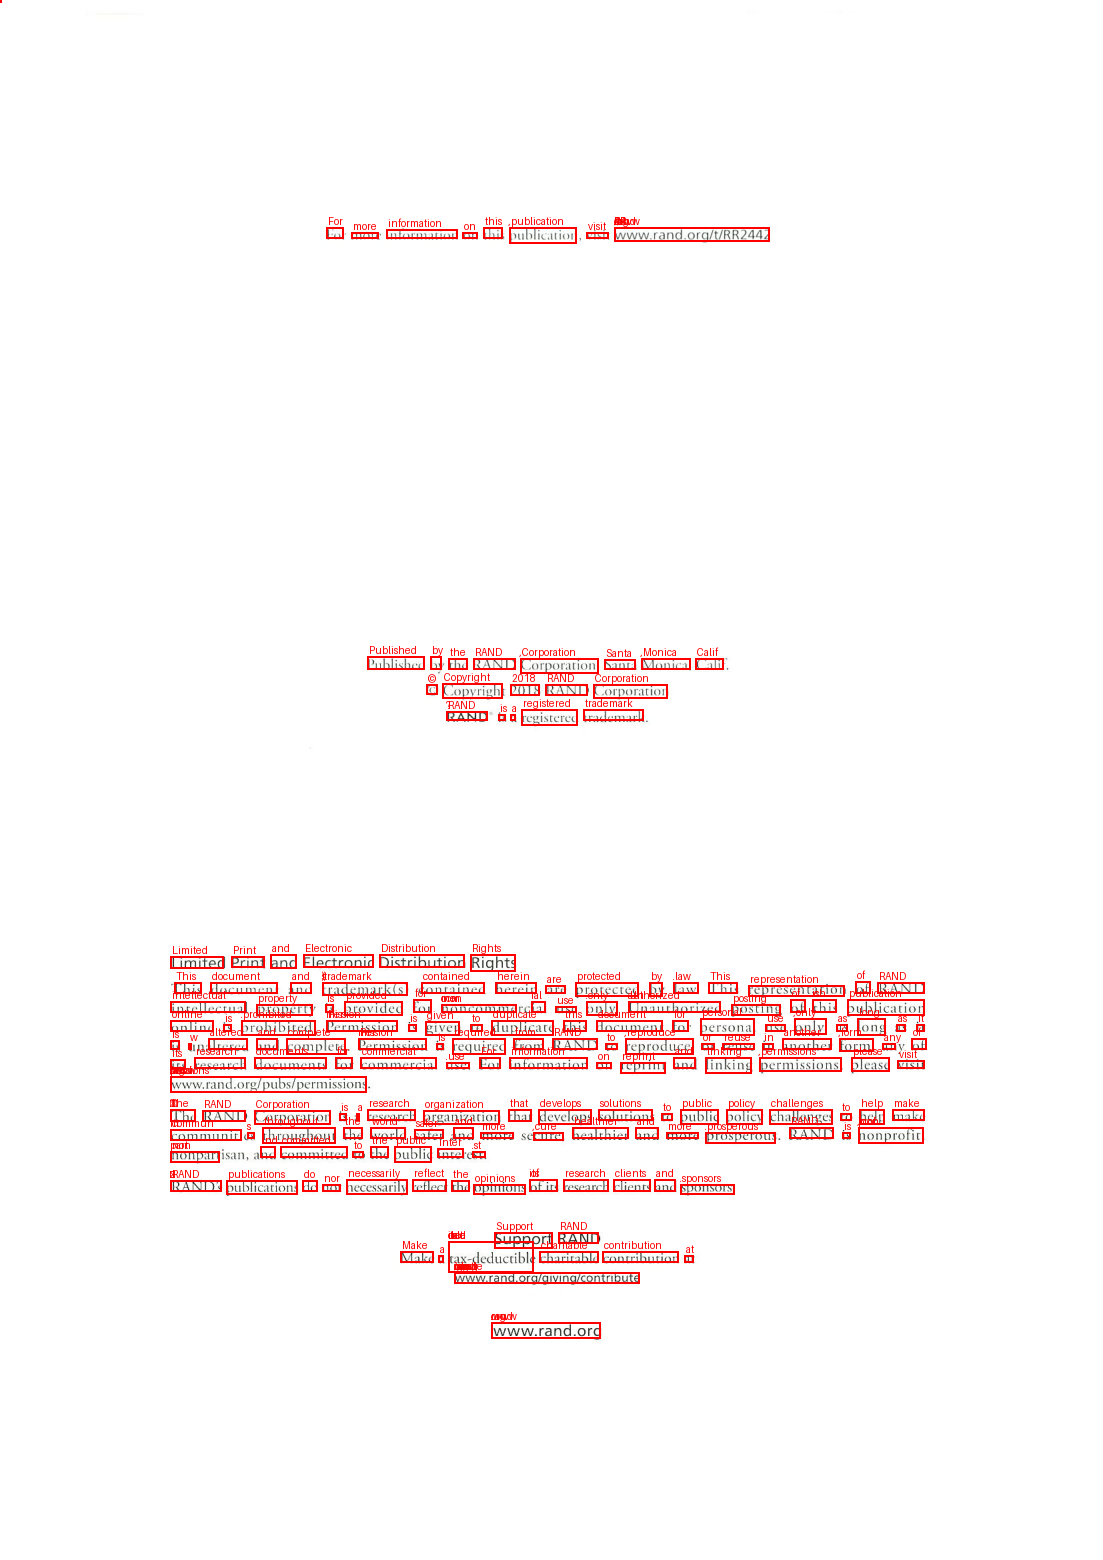

In [27]:
from PIL import Image, ImageDraw, ImageFont

def visualize_layoutlm_boxes(image, encoding, color="red", width=2, show_ids=False):
    """
    Draw LayoutLMv2/v3 WordPiece bounding boxes on the image.
    
    image: PIL Image (original image)
    encoding: output of processor(image, ...)
    """
    img = image.copy()
    draw = ImageDraw.Draw(img)
    
    W, H = img.size
    bboxes = encoding["bbox"][0].tolist()
    input_ids = encoding["input_ids"][0].tolist()

    # Optional font for text labels
    try:
        font = ImageFont.truetype("arial.ttf", 16)
    except:
        font = ImageFont.load_default()

    for idx, box in enumerate(bboxes):
        x0, y0, x1, y1 = box
        
        # Convert 0–1000 coords to pixel coords
        x0 = int(x0 / 1000 * W)
        y0 = int(y0 / 1000 * H)
        x1 = int(x1 / 1000 * W)
        y1 = int(y1 / 1000 * H)

        # Draw box
        draw.rectangle([(x0, y0), (x1, y1)], outline=color, width=width)

        # Optional: show token id or token text
        if show_ids:
            token = processor.tokenizer.decode([input_ids[idx]])
            draw.text((x0, y0 - 12), token, fill=color, font=font)

    return img

            
vis = visualize_layoutlm_boxes(image, encoding, show_ids=True)
display(vis)